## smFISH validation of astrocytes in the mouse brain

!pip install opencv-python
!pip install dask_image --upgrade
!pip install scikit-image --upgrade
!pip install imageio --upgrade

In [1]:
import glob
from dask_image.imread import imread
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#import cell2location

import sys
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

In [2]:
# Load quantified data from segmentation maps
path_measurement = '/nfs/team283_imaging/VK_C2L/playground_Tong/ilastik/measurements_filtered/'
fig_path = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/smFISH_validation/'

slide_id = 'VK_C2L_O14B_DAHN58.1d_Nucleus_Slc38a1_Agt_Slc1a3_Aldh1a1_Meas1b_A2_F2T0'
figure_id = 'Fig3E_O14B_F2T0'

aldh1a1_file = f'{slide_id}.ome_Alexa_647.csv'
agt_file = f'{slide_id}.ome_Alexa_568.csv'

agt = pd.read_csv(f'{path_measurement}{agt_file}', index_col='label')
aldh1a1 = pd.read_csv(f'{path_measurement}{aldh1a1_file}', index_col='label')

In [3]:
agt['mean_intensity'].describe(), aldh1a1['mean_intensity'].describe()

(count    8875.000000
 mean      935.341467
 std       298.105403
 min       482.670543
 25%       704.695453
 50%       866.982287
 75%      1094.928490
 max      3388.852478
 Name: mean_intensity, dtype: float64,
 count    8875.000000
 mean      160.174068
 std        29.579351
 min       120.640199
 25%       139.905410
 50%       152.852580
 75%       172.310178
 max       515.138112
 Name: mean_intensity, dtype: float64)

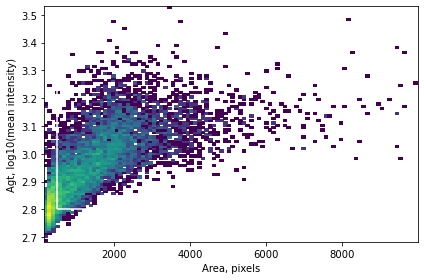

In [4]:
plt.hist2d(agt['area'].values, np.log10(agt['mean_intensity'].values), 
           bins = 100, norm=matplotlib.colors.LogNorm());
plt.xlabel('Area, pixels');
plt.ylabel('Agt, log10(mean intensity)');
plt.title('');
plt.tight_layout();
plt.hlines(2.8, 500, 7000, color='white');
plt.vlines(500, 2.8, 3.7, color='white');

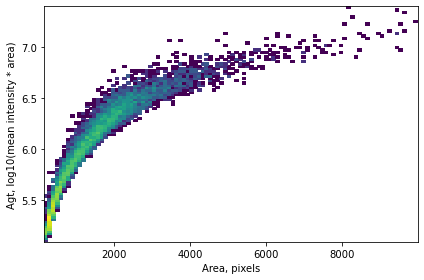

In [5]:
plt.hist2d(agt['area'].values, np.log10(agt['mean_intensity'].values * agt['area'].values), 
           bins = 100, norm=matplotlib.colors.LogNorm());
plt.xlabel('Area, pixels');
plt.ylabel('Agt, log10(mean intensity * area)');
plt.title('');
plt.tight_layout();
plt.hlines(2.8, 500, 7000, color='white');
plt.vlines(500, 2.8, 3.7, color='white');

In [6]:
#agt = agt.loc[np.array(agt['area'] > 500) & np.array(np.log10(agt['mean_intensity'].values) > 2.8),:]
#aldh1a1_all = aldh1a1.copy()
#aldh1a1 = aldh1a1.loc[agt.index,:]
#lgr6 = lgr6.loc[agt.index,:]
#agt.to_csv(f'{path_measurement}filtered{agt_file}')

## Load raw images

In [7]:
# Load image data
paths_glob = ["/nfs/team283_imaging/0HarmonyStitched/VK_C2L/200917_182515-V__2020-09-17T18_38_24-Measurement 1b/",
    "/nfs/team283_imaging/0HarmonyStitched/JSP_HSS/200924_202612-V__2020-09-24T20_53_38-Measurement 1b/",
    "/nfs/team283_imaging/0HarmonyStitched/JSP_HSS/200924_221940-V__2020-09-24T22_46_54-Measurement 1b/"]
paths = glob.glob(f'{paths_glob[0]}*.ome.tif')

imgs = imread(f'{paths_glob[0]}{slide_id}.ome.tif')

In [8]:
paths

['/nfs/team283_imaging/0HarmonyStitched/VK_C2L/200917_182515-V__2020-09-17T18_38_24-Measurement 1b/VK_C2L_O14B_DAHN58.1d_Nucleus_Slc38a1_Agt_Slc1a3_Aldh1a1_Meas1b_A2_F1T0.ome.tif',
 '/nfs/team283_imaging/0HarmonyStitched/VK_C2L/200917_182515-V__2020-09-17T18_38_24-Measurement 1b/VK_C2L_O14B_DAHN58.1d_Nucleus_Slc38a1_Agt_Slc1a3_Aldh1a1_Meas1b_A2_F3T0.ome.tif',
 '/nfs/team283_imaging/0HarmonyStitched/VK_C2L/200917_182515-V__2020-09-17T18_38_24-Measurement 1b/VK_C2L_O14B_DAHN58.1d_Nucleus_Slc38a1_Agt_Slc1a3_Aldh1a1_Meas1b_A2_F2T0.ome.tif']

## Load segmentation masks

In [9]:
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import tifffile #pip install tifffile

def color_tiff(img):
    img = img%60
    seg_color = np.zeros((*img.shape, 3), dtype=np.uint8)
    for i in tqdm(range(1, img.max()+1)):
        seg_color[img==i] = np.random.randint(0, 255, 3)
    return seg_color

masks_path = '/nfs/team283_imaging/VK_C2L/playground_Tong/ilastik/blurred_2_iter_closing/'
my_masks_path = '/nfs/team283_imaging/VK_C2L/playground_vitalii/masks/'

segm_img = tifffile.imread(f'{masks_path}{slide_id}.ome_mask_agt_closed_2.tif')
colored_segm_img = color_tiff(segm_img)
#plt.imshow(colored_segm_img)
#plt.show()

In [10]:
def prepare_image(imgs, colored_segm_img=None, layer_num=0, alpha=0.5, 
                  resize_factor=None, rescale_intensities=(150, 500)):

    img_layer = imgs[layer_num].compute()

    # Get the color map by name:
    cm = plt.get_cmap('Greys_r')

    if colored_segm_img is not None:
        
        img_layer = np.clip(img_layer, rescale_intensities[0], rescale_intensities[1]) # rescale intensities
        img_layer -= img_layer.min()
        
        # Apply the colormap like a function to any array:
        img_layer = cm(img_layer)[:, :, :3] * 255
        
        binary_mask = np.zeros_like(img_layer)
        for i in range(img_layer.shape[2]):
            binary_mask[:, :, i] = segm_img > 0
        img_layer = img_layer * (1 - binary_mask) \
        + img_layer * binary_mask * alpha \
        + colored_segm_img * (1 - alpha)
    
    if resize_factor is not None:
        
        new_dim = (np.array(img_layer.shape)[::-1] * resize_factor).astype(int)
        img_layer = cv.resize(img_layer, (new_dim[0], new_dim[1]))
        
    if colored_segm_img is None:
        
        img_layer = np.clip(img_layer, rescale_intensities[0], rescale_intensities[1]) # rescale intensities
        img_layer = img_layer - img_layer.min()
        
        # Apply the colormap like a function to any array:
        img_layer = cm(img_layer)[:, :, :3] * 255
    
    return img_layer.astype(int)

### Full brain maps with background

In [11]:
# aldh1a1 in astros with Agt background
from cell2location.plt.mapping_video import plot_spatial

resize_factor = 1 / 10

img_layer_small = prepare_image(imgs, colored_segm_img=None, 
                                layer_num=0, alpha=0.5, 
                                resize_factor=resize_factor,
                                rescale_intensities=(150, 500))

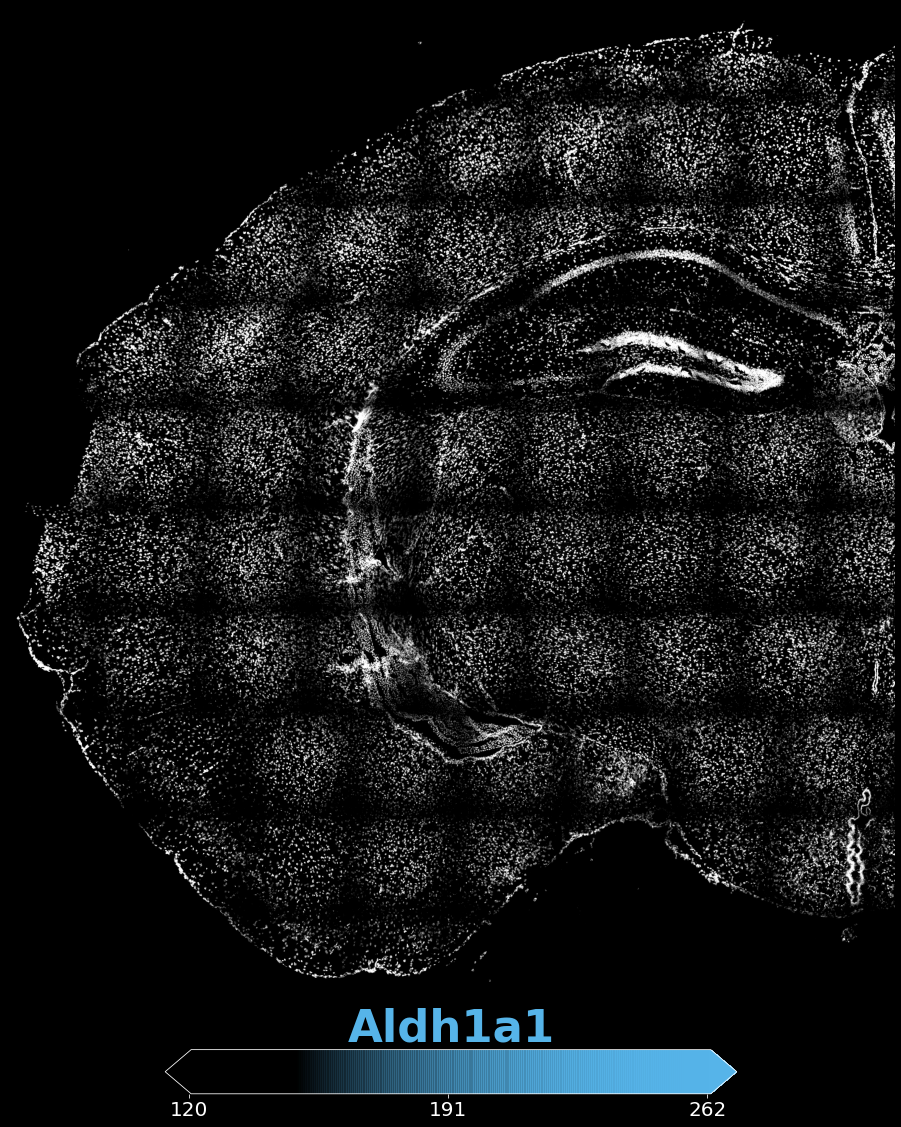

In [12]:
with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(aldh1a1[['mean_intensity']], labels=['Aldh1a1'],
                  coords=aldh1a1[['centroid-1', 'centroid-0']].values * resize_factor, 
                  img=img_layer_small, show_img=True, img_alpha=1,
                  circle_diameter=3, alpha_scaling=0, reorder_cmap=[2, 0, 1],
                  plt_axis='off', style='dark_background',
                  max_color_quantile=0.99, image_cmap='Greys_r',
                  crop_x=[50, 1750], crop_y=[20, 1900], axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)
    
    fig.savefig(f'{fig_path}{figure_id}_DAPI.pdf',
                bbox_inches='tight', facecolor='white')

### Full brain maps WITHOUT background

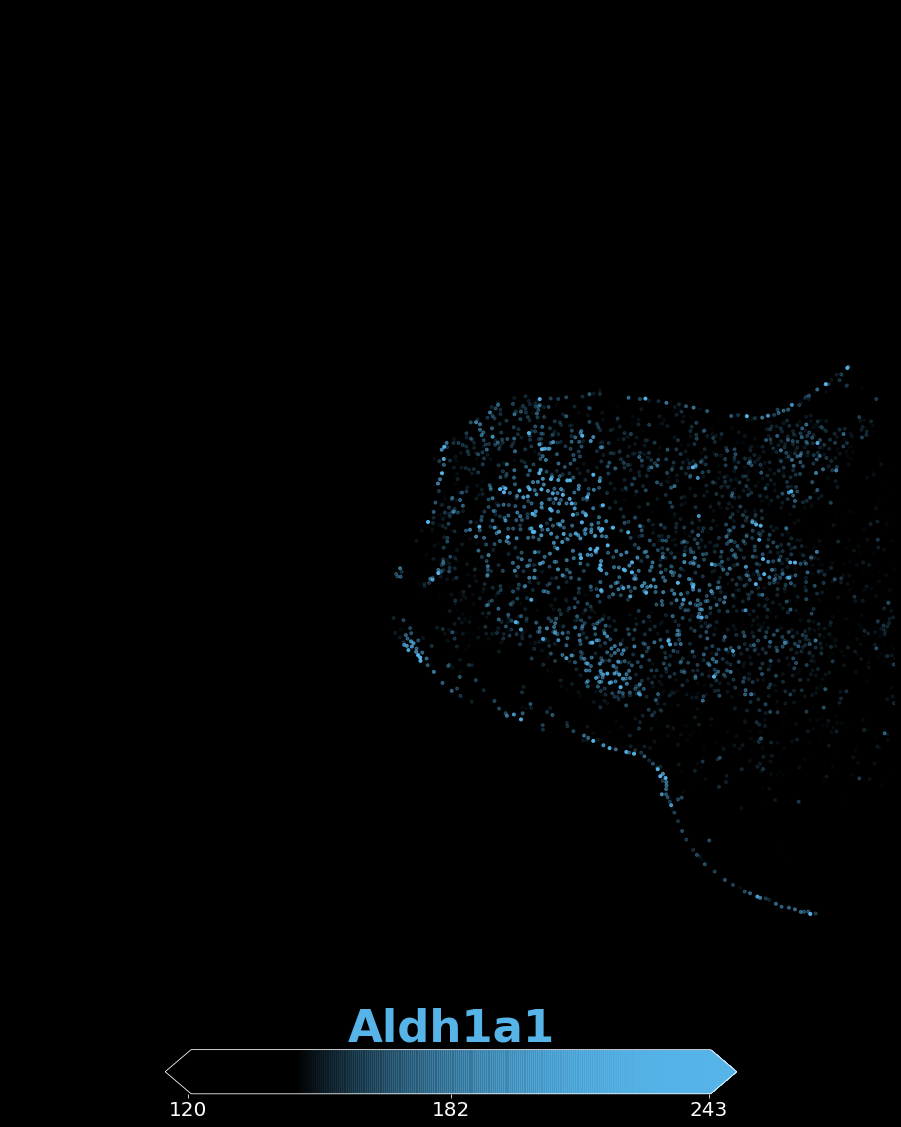

In [13]:
# aldh1a1 in astros
from cell2location.plt.mapping_video import plot_spatial

with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(aldh1a1[['mean_intensity']], labels=['Aldh1a1'],
                  coords=aldh1a1[['centroid-1', 'centroid-0']].values * resize_factor, 
                  img=img_layer_small, show_img=True, img_alpha=0,
                  circle_diameter=3, alpha_scaling=1, reorder_cmap=[2, 0, 1],
                  plt_axis='off', style='dark_background',
                  max_color_quantile=0.98, image_cmap='Greys_r',
                  crop_x=[50, 1750], crop_y=[20, 1900], axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)
    
    fig.savefig(f'{fig_path}{figure_id}_Aldh1a1.pdf',
                bbox_inches='tight', facecolor='white')

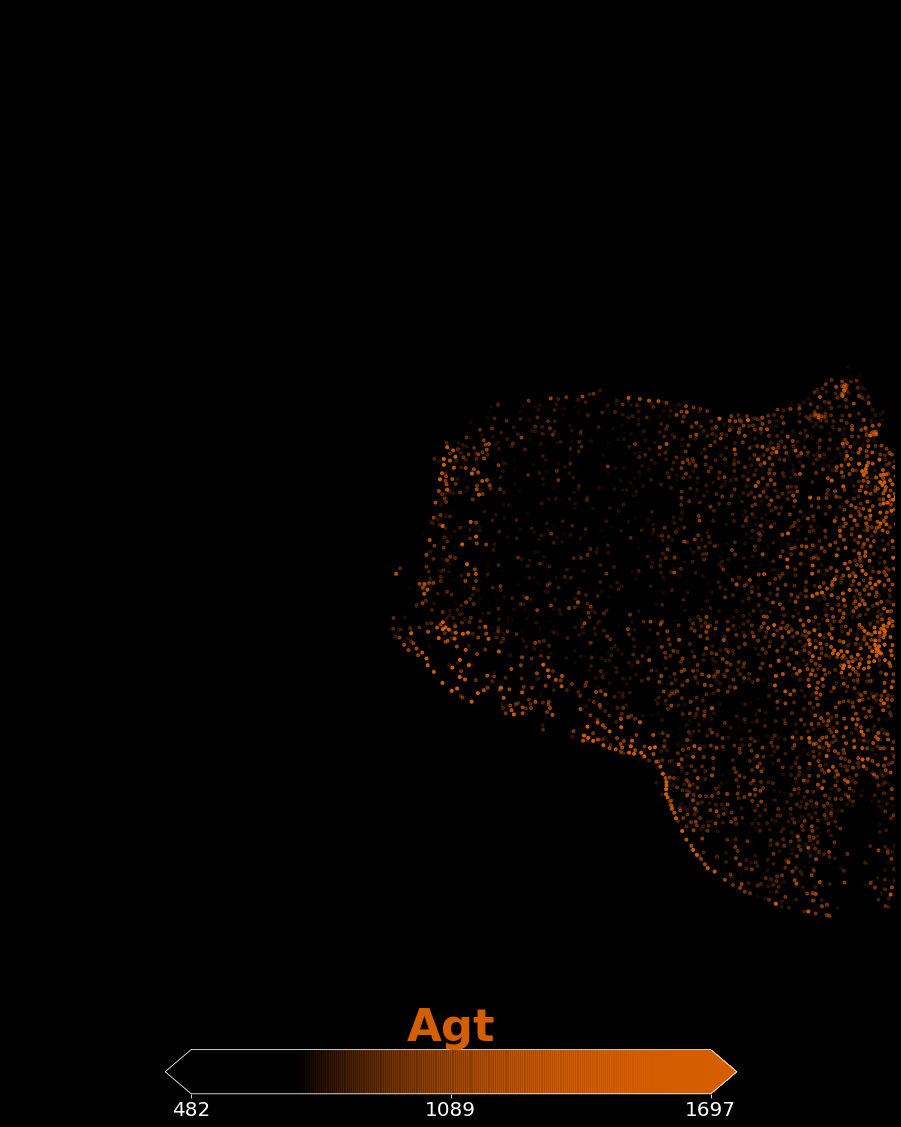

In [14]:
# Agt in astros 
with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(agt[['mean_intensity']], labels=['Agt'],
                  coords=agt[['centroid-1', 'centroid-0']].values * resize_factor, 
                  img=img_layer_small, show_img=True, img_alpha=0,
                  circle_diameter=3, alpha_scaling=1, reorder_cmap=[1],
                  plt_axis='off', style='dark_background',
                  max_color_quantile=0.98, image_cmap='Greys_r',
                  crop_x=[50, 1750], crop_y=[20, 1900], axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)
    
    fig.savefig(f'{fig_path}{figure_id}_Agt.pdf',
                bbox_inches='tight', facecolor='white')

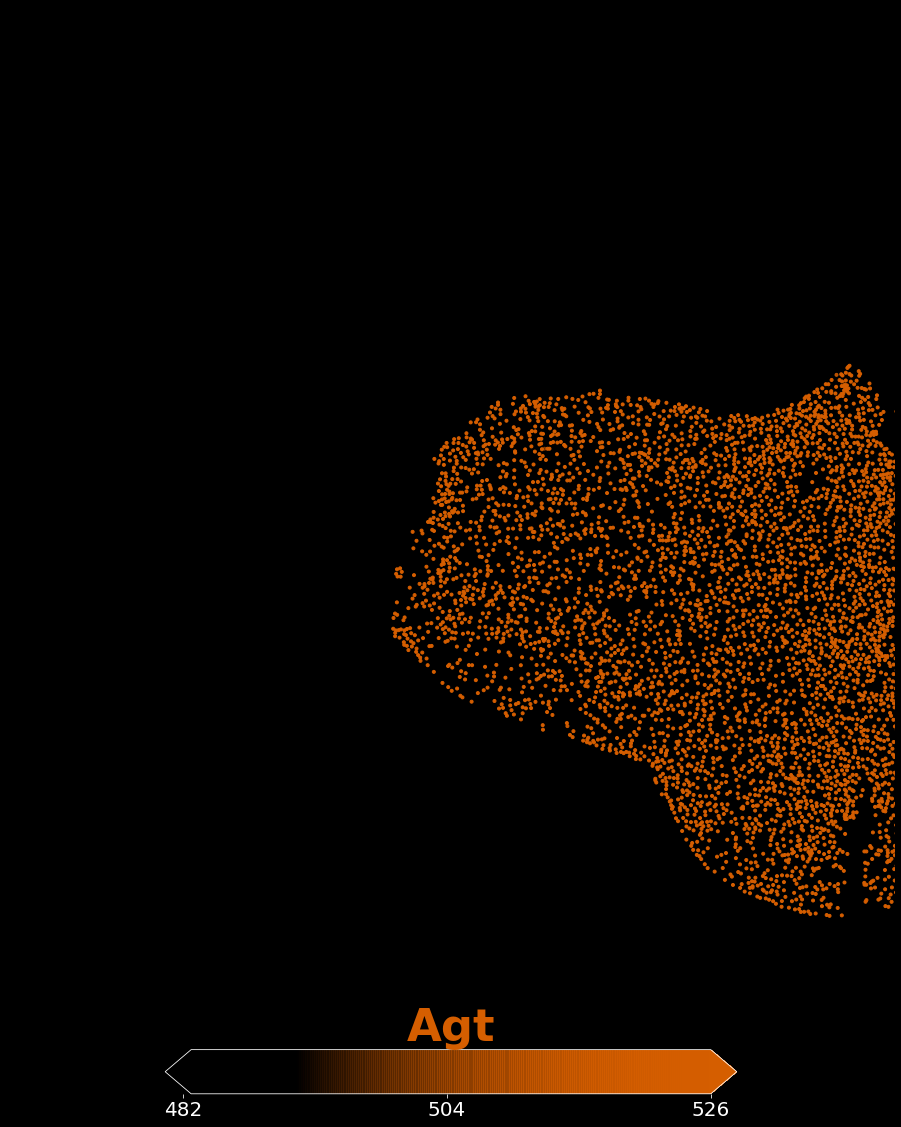

In [15]:
# Show all astros
with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(agt[['mean_intensity']], labels=['Agt'],
                  coords=agt[['centroid-1', 'centroid-0']].values * resize_factor, 
                  img=img_layer_small, show_img=True, img_alpha=0,
                  circle_diameter=3, alpha_scaling=1, reorder_cmap=[1],
                  plt_axis='off', style='dark_background',
                  max_color_quantile=0.001, image_cmap='Greys_r',
                  crop_x=[50, 1750], crop_y=[20, 1900], axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)
    
    fig.savefig(f'{fig_path}{figure_id}_Agt_all.pdf',
                bbox_inches='tight', facecolor='white')